<a href="https://colab.research.google.com/github/andreaaraldo/machine-learning-for-networks/blob/master/06.clustering-and-anomaly/06.c.autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import average_precision_score, precision_score, \
                        recall_score, precision_recall_curve, roc_curve, \
                        roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler



# I prepared these libraries for you
! wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/andrea_models.py
! wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py
from andrea_models import subsample
from visualization import silhouette_diagram, plot_conf_mat, \
                      false_positive_rate, evaluate_anomaly_detector

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard



# The following is to be able to mount Google Drive
from google.colab import drive

import os
from os.path import isfile
import datetime
import shutil
from functools import partial, partialmethod



# The following library is to plot the loss during training
# https://github.com/stared/livelossplot
! pip install livelossplot
from livelossplot import PlotLossesKerasTF


# To show time at each cell
# Credits to https://medium.com/@arptoth/how-to-measure-execution-time-in-google-colab-707cc9aad1c8
!pip install ipython-autotime
%load_ext autotime

--2021-05-04 08:43:22--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/andrea_models.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3190 (3.1K) [text/plain]
Saving to: ‘andrea_models.py’

andrea_models.py    100%[===================>]   3.12K  --.-KB/s    in 0s      

2021-05-04 08:43:23 (37.2 MB/s) - ‘andrea_models.py’ saved [3190/3190]

--2021-05-04 08:43:23--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


time: 188 µs (started: 2021-05-04 08:43:32 +00:00)


### Mount google drive

In [ ]:
mount_point = '/content/gdrive' # Always the same, don't change it
drive.mount(mount_point, force_remount=True)
drive_path = mount_point + '/My Drive/' # Always the same, don't change it
my_path = drive_path + \
  'tsp/teaching/data-science-for-networks/img-from-code/06.clustering-and-anomaly/'

Mounted at /content/gdrive
time: 26.7 s (started: 2021-05-04 08:43:32 +00:00)


### Preprocessing

The following code is the same as in the [previous notebook](https://github.com/andreaaraldo/machine-learning-for-networks/blob/master/06.clustering-and-anomaly/06.a.kmeans-anomaly.ipynb).

In [ ]:
np.random.seed(9)
random.seed(9)
tf.random.set_seed(4)

#Downaload link updated
! wget -O creditcard.csv \
  "https://dl.dropboxusercontent.com/scl/fi/6n89gfhs4fg3xetlc04dd/creditcard.csv?rlkey=mkboeg92cpnkinhvmeus3ek09"

df = pd.read_csv('creditcard.csv')


df = df.drop('Time', axis=1)
X = df.drop('Class', axis=1)
y = [1 if c=="'1'" else 0 for c in df['Class']]

--2021-05-04 08:43:59--  https://datahub.io/machine-learning/creditcard/r/creditcard.csv
Resolving datahub.io (datahub.io)... 104.21.40.221, 172.67.157.38, 2606:4700:3030::ac43:9d26, ...
Connecting to datahub.io (datahub.io)|104.21.40.221|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://pkgstore.datahub.io/machine-learning/creditcard/creditcard_csv/data/ebdc64b6837b3026238f3fcad3402337/creditcard_csv.csv [following]
--2021-05-04 08:44:00--  https://pkgstore.datahub.io/machine-learning/creditcard/creditcard_csv/data/ebdc64b6837b3026238f3fcad3402337/creditcard_csv.csv
Resolving pkgstore.datahub.io (pkgstore.datahub.io)... 104.21.40.221, 172.67.157.38, 2606:4700:3030::ac43:9d26, ...
Connecting to pkgstore.datahub.io (pkgstore.datahub.io)|104.21.40.221|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 151114991 (144M) [text/csv]
Saving to: ‘creditcard.csv’

creditcard.csv      100%[===================>] 144.11M  21.9MB/s    in 7

To perform model selection, i.e., selecting the best configuration, we will use the ground truth (the normal-anomaly label) and compute the precision-recall curves and the ROC curve.

To avoid **data leakage**, we perform model selection on the training set only

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5,
                                      random_state=9)


time: 658 ms (started: 2021-05-04 08:44:10 +00:00)



We also scale the dataset.

In [ ]:
scaler = StandardScaler()
X_tr_scaled = scaler.fit_transform(X_train)

time: 56.1 ms (started: 2021-05-04 08:44:10 +00:00)


In [ ]:
n_features = X_tr_scaled.shape[1]
print("The number of features is ", n_features)


The number of features is  29
time: 2.17 ms (started: 2021-05-04 08:44:10 +00:00)


# Functions to build and train a neural net

Let's write the functions to build and train the model, similar to what we did in our [Neural Network's notebook](https://github.com/andreaaraldo/machine-learning-for-networks/tree/master/04.neural_networks).

In [ ]:
def make_sequential_model(sample_size, layer_sizes,
                          hidden_activation_function="relu",
                          out_activation_function="softmax",
                          loss_fun="categorical_crossentropy",
                          learning_rate=0.01,
                          regularization_coeff=0,
                          metrics=['accuracy']):
  """
  Makes a sequential model.
  Parameters
  -------------------------
  sample_size: integer
    The number of features of the samples

  layer_sizes: list
    List of the size of the neural network layers. For instance, if
    layer_sizes = [8, 6, 4], the 1st layer will have 5 neurons, the 2nd 6 etc.
    Attention: the size of the last layer (the output layer) is not arbitrary.
    In case of monodimensional regression, it must be 1.
    When using categorical_crossentropy, it must be the same as the number of
    categories.
    When using binary_crossentropy, it must be 1.

  inner_activation_function: string
    Activation function used in all layers, except the last one.
    Ex: "relu"

  out_activation_function: string
    Activation function of the last layer.
    Ex. "softmax"

  loss_fun: string
    The loss function we want to minimize. Ex. categorical_crossentropy

  learning_rate: float
    Ex. 0.01

  regularization_coeff: float
    Coefficient of ridge regression
    Ex. 0.01

  metrics: list of strings
    The metrics we want to show during training. Ex. ['accuracy']
  """

  model = Sequential()


  # In the next code we will use `partial`, which is a function of the ptyhon
  # library functools, which allows to define a class, identical to another
  # class but with some different default values.
  # In our case we define MyDenseLayer equal to the standard keras class
  # `Dense`, which implements a simple neural network layer, specifying
  # two default values: one for the activation function, and another for the
  # regularization

  if (regularization_coeff==0):
    # No regularization
    MyDenseLayer = partial(Dense, activation=hidden_activation_function)
  else:
    MyDenseLayer = partial(Dense, activation=hidden_activation_function,
                         kernel_regularizer=keras.regularizers.l2(regularization_coeff))

  # Add the input layer
  model.add( MyDenseLayer(layer_sizes[0],
                  input_dim = sample_size) )

  # Add hidden layers
  for i in range(1,len(layer_sizes)-1 ): # We iterate from the 2nd element to the penultimate
    model.add( MyDenseLayer(layer_sizes[i]) )

  # Add output layer
  model.add( Dense(layer_sizes[-1],
                  activation = out_activation_function) )


  model.compile(loss=loss_fun,
              optimizer=keras.optimizers.Adam(lr=learning_rate) ,
              metrics=metrics)

  return model

time: 24.2 ms (started: 2021-05-04 08:44:10 +00:00)


In [ ]:
def enforce_reproducibility(seed):
  tf.keras.backend.clear_session()

  # To know more:
  #       https://machinelearningmastery.com/reproducible-results-neural-networks-keras/
  random.seed(seed)
  np.random.seed(random.randint(0,300000))
  tf.random.set_seed(random.randint(0,300000))

time: 2.93 ms (started: 2021-05-04 08:44:10 +00:00)


In [ ]:
def train_model(model, nn_file, X_tr, y_tr, seed, max_epochs=1000,
                overwrite=True, validation_split=0.2, patience=10):
  """
  model: neural network model
            It must be a compiled neural network, e.g., a model issued by the
            function make_sequential_model(..) defined before

  nn_file:  string (name of a file)
            This file will be used to store the weights of the trained neural
            network. Such weights are automatically stored during training
            (thanks to the ModelCheckpoint callback (see the implementation
            code)), so that even if the code fails in the middle of training,
            you can resume training without starting from scratch.
            If the file already exists, before starting training, the weights
            in such a file will be loaded, so that we do not start training from
            scratch, but we start already from (hopefully) good weigths.

  overwrite: boolean
            If true, the model will be built and trained from scratch,
            indipendent of whether nn_file exists or not.

  seed: integer

  X_tr: matrix
            Feature matrix of the training set

  y_tr: matrix
            True labels of the training set

  max_epochs: integer
            Training will stop after such number of epochs

  validation_split: float (between 0 and 1)
            Fraction of training dataset that will be used as validation

  patience: integer
            Training will stop if the validation loss does not improve after the
            specified number of epochs
  """

  enforce_reproducibility(seed)


  # Before starting training, Keras divides (X_tr, y_tr) into a training subset
  # and a validation subset. During iterations, Keras will do backpropagation
  # in order to minimize the loss on the trainins subset, but it will monitor
  # and also plot the loss on the validation subset.
  # However, Keras always takes the first part of (X_tr, y_tr) as training
  # subset and the second part as validation subset. This can be bad, in case
  # the dataset has been created with a certain order (for instance all the
  # samples with a certain characteristic first, and then all the others), as
  # we instead need to train the neural network on a representative subset of
  # samples. For this reason, we first shuffle the dataset
  X_train, y_train = shuffle(X_tr, y_tr, random_state=seed)


  ##################
  #### CALLBACKS ###
  ##################
  # These functions are called at every epoch
  plot_cb = PlotLossesKerasTF()  # Plots the loss
  checkpoint_cb = ModelCheckpoint(nn_file) # Stores weights
  logger_cb = CSVLogger(nn_file+'.csv', append=True) # Stores history
                # see https://theailearner.com/2019/07/23/keras-callbacks-csvlogger/


  # To stop early if we already converged
  # See pagg 315-16 of [Ge19]
  early_stop_cb = tf.keras.callbacks.EarlyStopping(verbose=1,
      monitor='val_loss',
     patience=patience, restore_best_weights=True)


  if overwrite==True:
    try:
      os.remove(nn_file)
    except OSError:
      pass

    try:
      os.remove(nn_file+'.csv')
    except OSError:
      pass

  if isfile(nn_file):
    print("Loading pre-existing model")
    model = load_model(nn_file)

  history = model.fit(X_train, y_train, epochs=max_epochs,
                      callbacks = [plot_cb, checkpoint_cb, logger_cb, early_stop_cb],
                      validation_split=validation_split )

  return history

time: 22.2 ms (started: 2021-05-04 08:44:10 +00:00)


# Autoencoder

In [ ]:
first_architecture = [10, 5, 10, n_features]
# The encoder is composed of the input layer, with one input per feature
#    and a layer of 10 neurons
# The latent representation is composed of one layer of 5 neurons
# The decoder is composed of a layer of 10 neurons and the output layer
#

time: 1.84 ms (started: 2021-05-04 00:46:25 +00:00)


Instead of always calling `make_sequential_model(..)` specifying many parameters (that will basically not change all over this notebook, let us use the function `partial` from Python `functools` library

In [ ]:
make_autoencoder = partial(make_sequential_model, sample_size=n_features,
                        hidden_activation_function='tanh',
                      out_activation_function='tanh',
                      loss_fun='mean_squared_error',
                      metrics=[])

time: 4.49 ms (started: 2021-05-04 07:01:07 +00:00)


We can now call directly this function `make_autoencoder`

In [ ]:
model = make_autoencoder(layer_sizes=first_architecture)

time: 5.25 s (started: 2021-05-04 00:46:25 +00:00)


We can now train this model

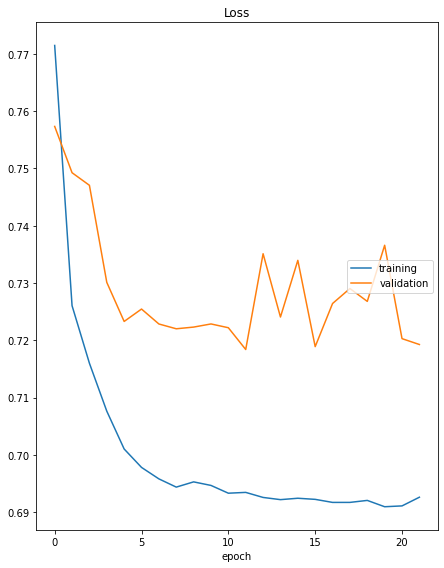

Loss
	training         	 (min:    0.691, max:    0.771, cur:    0.693)
	validation       	 (min:    0.718, max:    0.757, cur:    0.719)
Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
time: 2min 59s (started: 2021-05-04 00:46:30 +00:00)


In [ ]:
nn_file = my_path + 'nn1.h5'

history = train_model(model, nn_file, X_tr_scaled, X_tr_scaled, seed=5,
                      max_epochs=200)

The validation loss stops to decrease too soon (only after 50 epochs). It may be due to the learning rate being too high (in the declaration of the function `make_sequential_model`, the default learning rate is 0.02). Let's try with a smaller one

In [ ]:
model = make_autoencoder(layer_sizes=first_architecture, learning_rate=0.001)

time: 44 ms (started: 2021-05-04 00:49:30 +00:00)


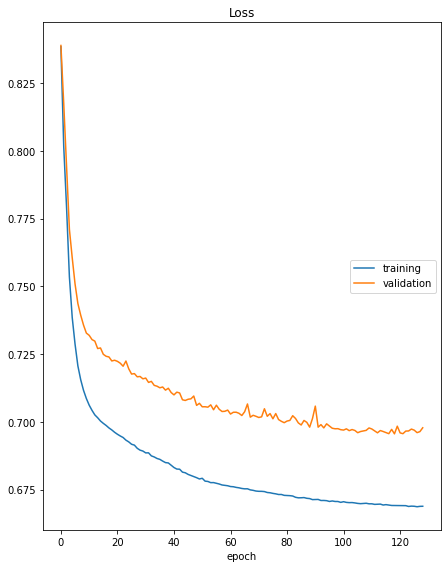

Loss
	training         	 (min:    0.669, max:    0.838, cur:    0.669)
	validation       	 (min:    0.696, max:    0.839, cur:    0.698)
Restoring model weights from the end of the best epoch.
Epoch 00129: early stopping
time: 17min (started: 2021-05-04 00:49:30 +00:00)


In [ ]:
nn_file = my_path + 'nn1-lr_0.001.h5'
history = train_model(model, nn_file, X_tr_scaled, X_tr_scaled, seed=5,
                      max_epochs=200)

We did not manage to remarkably decrease the loss.

Let's anyways try to see if we can construct a decent anomaly detector.

# First Anomaly detector

## Model selection: selecting the threshold

The **anomaly score** of each sample is the reconstruction error.

In [ ]:
X_tr_reconstr = model.predict(X_tr_scaled)
anomaly_scores = np.linalg.norm(X_tr_reconstr - X_tr_scaled, axis=1)

time: 2.9 s (started: 2021-05-04 01:06:30 +00:00)


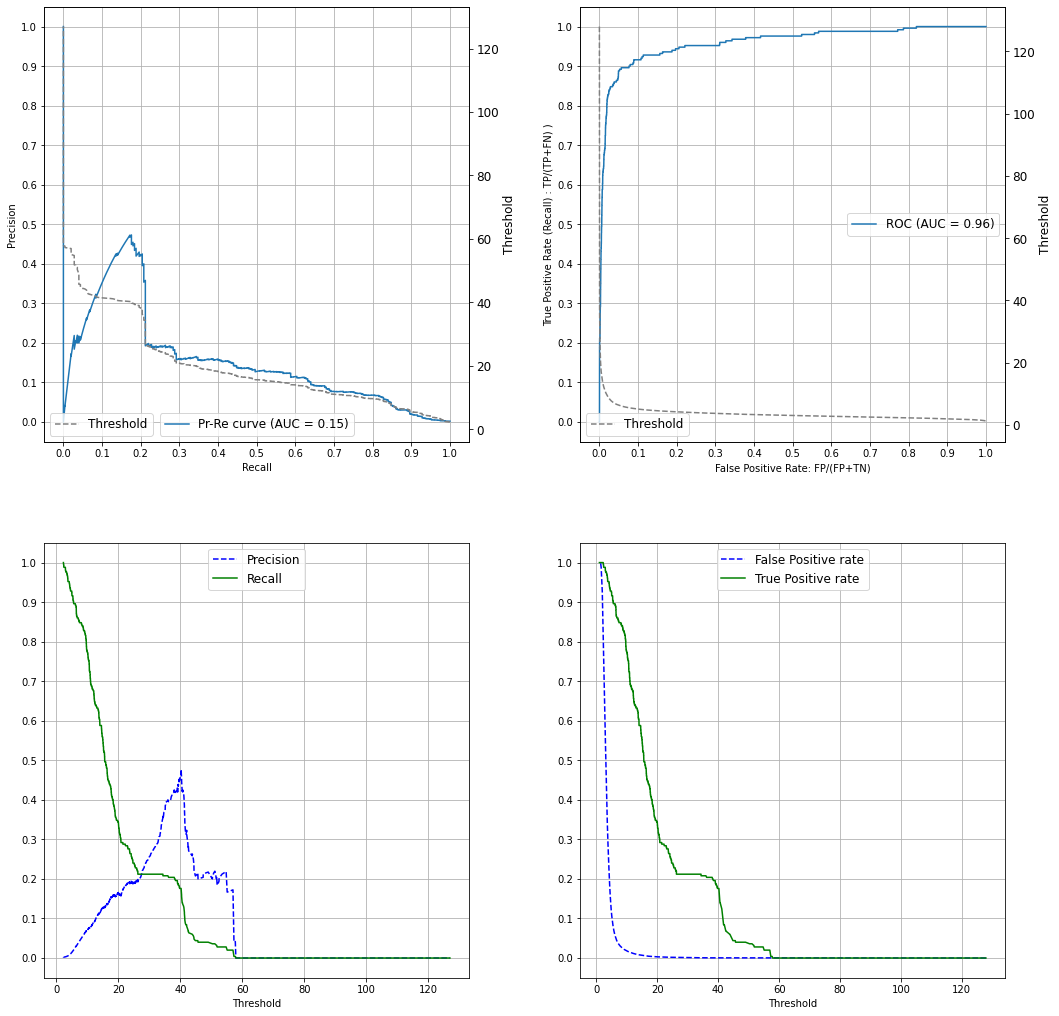

time: 1.36 s (started: 2021-05-04 01:06:33 +00:00)


In [ ]:
evaluate_anomaly_detector(y_train, anomaly_scores)

Look at the ROC curve (top right figure). It is possible to have a True Positive Rate (Recall) >= 90%, while having a false positive rate <= 10%.
In other words, we can construct an anomaly detector able to find 90% of the anomalies with less than 10% of false alarms.

Looking at the grey curve on that plot, we see that such a configuration is for threshold of about 5. Let us search for a good value of threshold.

Precision= 0.01451562006942253
Recall= 0.92
False Positive Rate =  0.10984643306859511
True Positive Rate =  0.92


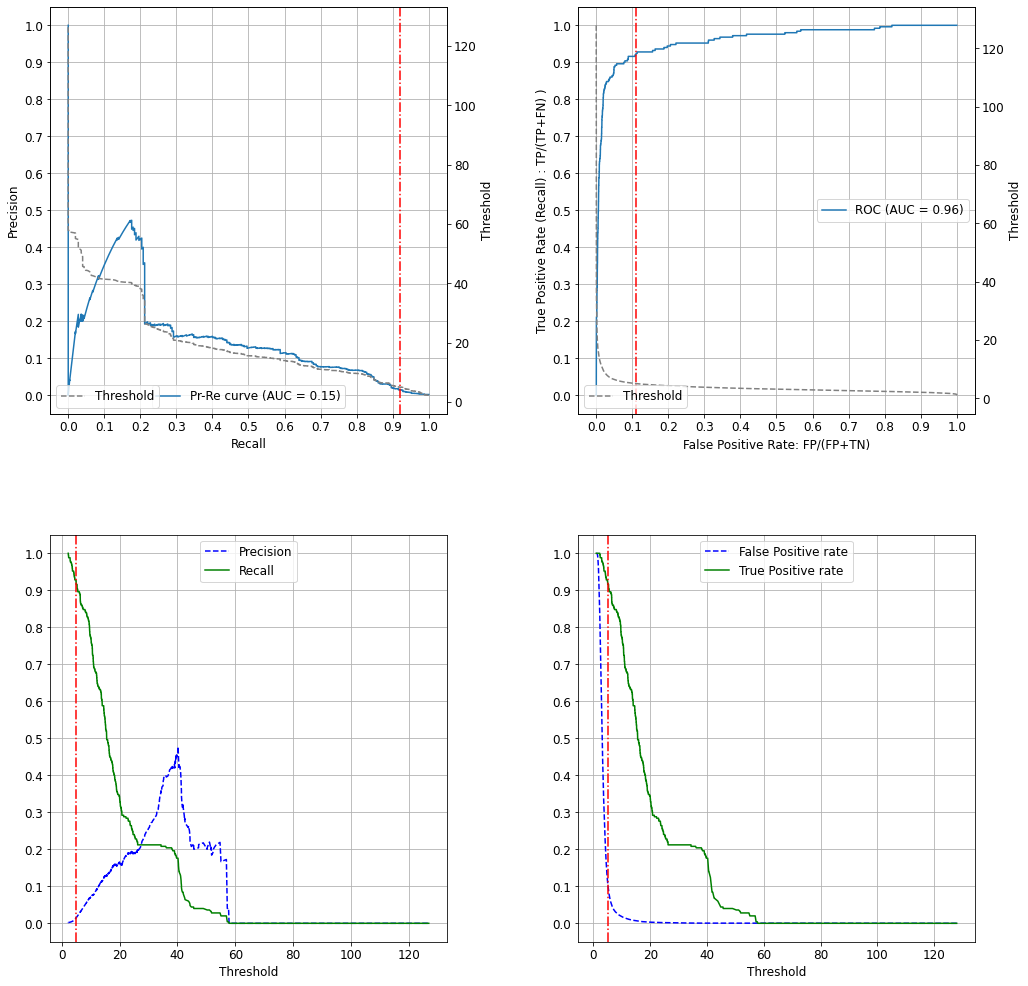

time: 2.24 s (started: 2021-05-04 01:06:34 +00:00)


In [ ]:
threshold_selected = 5
evaluate_anomaly_detector(y_train, anomaly_scores, threshold_selected)

## Evaluate the model on the test set

In [ ]:
X_test_scaled = scaler.transform(X_test)

time: 19.7 ms (started: 2021-05-04 08:49:30 +00:00)


In [ ]:
X_test_reconstr = model.predict(X_test_scaled)
anomaly_scores = np.linalg.norm(X_test_reconstr - X_test_scaled, axis=1)

y_pred = (anomaly_scores >= threshold_selected)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
fpr = false_positive_rate(y_test, y_pred)

print("Precision:", precision)
print("Recall: ", recall)
print("False Positive Rate:", fpr)


Precision: 0.013544303797468354
Recall:  0.8842975206611571
False Positive Rate: 0.10963548627622009
time: 3.37 s (started: 2021-05-04 01:06:36 +00:00)


* Precision 1.3%: when the model says "anomaly!", it is right 1.3% of the time.
* Recall 89%: the model captures 89% of the anomalies
* False positive rate 11%: 11% of normal samples are erroneously classified as anomalies

Normalized confusion matrix
[[0.89036451 0.10963549]
 [0.11570248 0.88429752]]


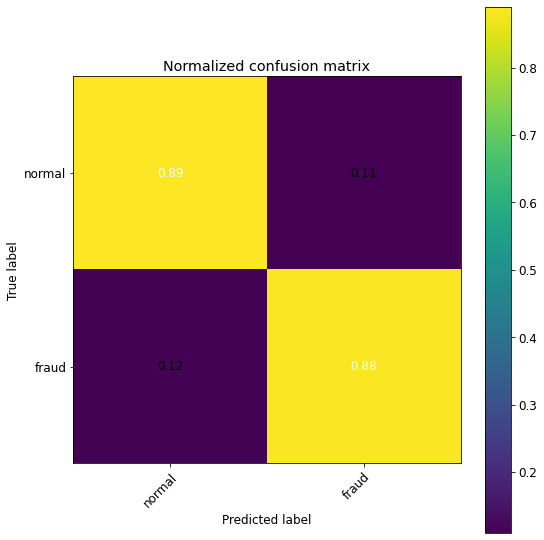

time: 636 ms (started: 2021-05-04 01:06:40 +00:00)


In [ ]:
class_names = np.array(["normal", "fraud"])
plot_conf_mat(y_test, y_pred, class_names)

The model is not bad, but we can further improve it.

# Second autoencoder: only using normal samples

We now train the auto-ecoder only on the normal samples

In [ ]:
# Select the normal samples
normal_samples_idx = [i for i in range(len(y_train)) if y_train[i]==0 ]
print("Found ", len(normal_samples_idx), "normal samples over ", len(y_train))

X_tr_normal = X_tr_scaled[normal_samples_idx, :]
X_tr_normal.shape

Found  142153 normal samples over  142403


(142153, 29)

time: 43.9 ms (started: 2021-05-04 01:06:40 +00:00)


In [ ]:
model = make_autoencoder(layer_sizes=first_architecture, learning_rate=0.005)

time: 48.5 ms (started: 2021-05-04 01:06:40 +00:00)


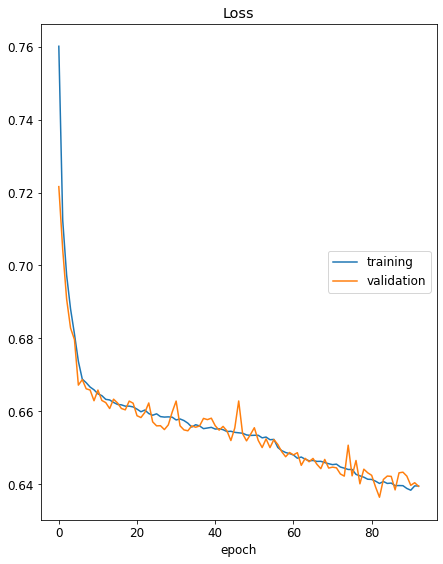

Loss
	training         	 (min:    0.638, max:    0.760, cur:    0.639)
	validation       	 (min:    0.636, max:    0.722, cur:    0.639)
Restoring model weights from the end of the best epoch.
Epoch 00093: early stopping
time: 12min 9s (started: 2021-05-04 01:06:41 +00:00)


In [ ]:
nn_file = my_path + 'nn-normal-samples-lr_0.005.h5'
history = train_model(model, nn_file, X_tr_normal, X_tr_normal, seed=5,
                      max_epochs=200)

In [ ]:
X_tr_reconstr = model.predict(X_tr_scaled)
anomaly_scores = np.linalg.norm(X_tr_reconstr - X_tr_scaled, axis=1)

time: 2.79 s (started: 2021-05-04 01:18:50 +00:00)


Precision= 0.015218685899556673
Recall= 0.92
False Positive Rate =  0.10469705176816528
True Positive Rate =  0.92


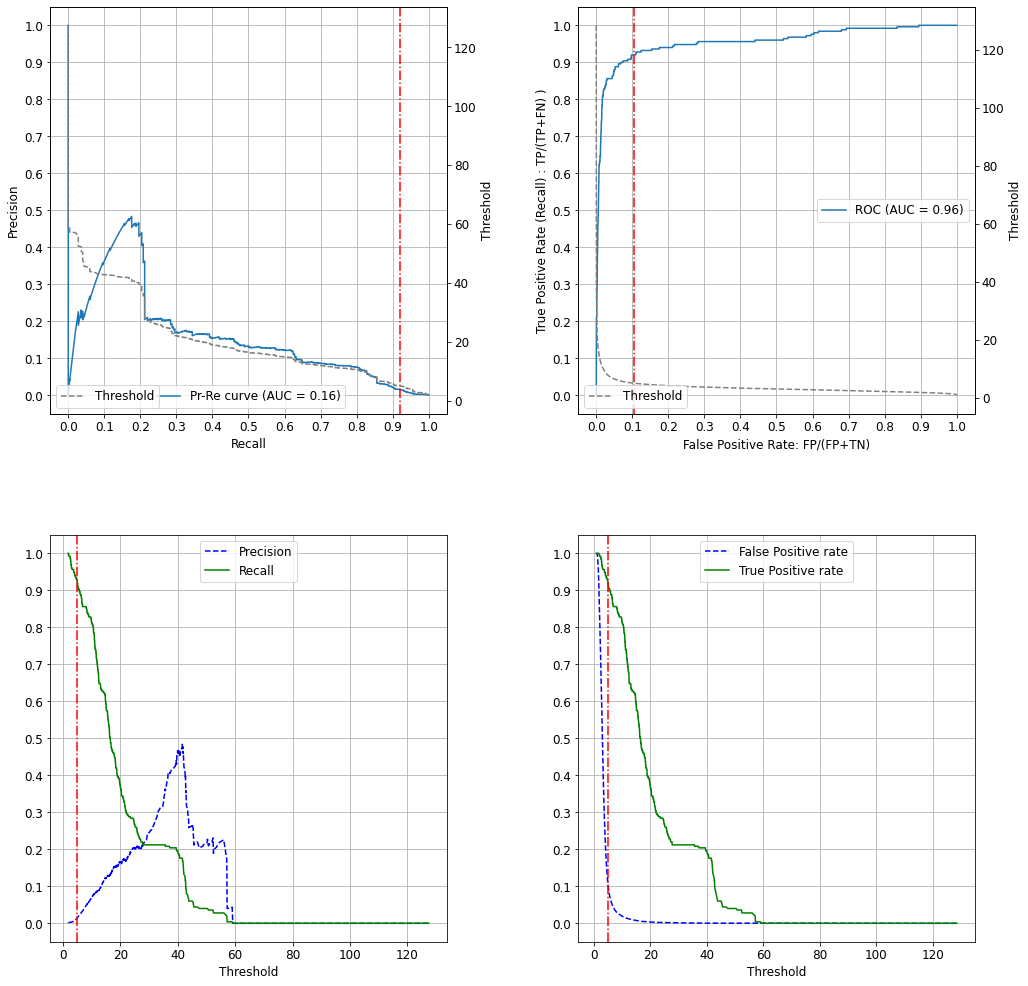

time: 2.2 s (started: 2021-05-04 01:18:53 +00:00)


In [ ]:
evaluate_anomaly_detector(y_train, anomaly_scores, threshold_selected)

In [ ]:
X_test_reconstr = model.predict(X_test_scaled)
anomaly_scores = np.linalg.norm(X_test_reconstr - X_test_scaled, axis=1)

y_pred = (anomaly_scores >= threshold_selected)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
fpr = false_positive_rate(y_test, y_pred)

print("Precision:", precision)
print("Recall: ", recall)
print("False Positive Rate:", fpr)

Precision: 0.014425003339121143
Recall:  0.8925619834710744
False Positive Rate: 0.10381114503172437
time: 3.35 s (started: 2021-05-04 01:18:55 +00:00)


Normalized confusion matrix
[[0.89618885 0.10381115]
 [0.10743802 0.89256198]]


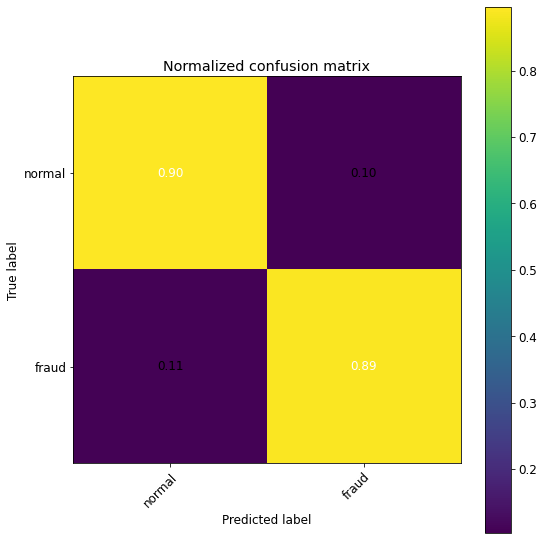

time: 622 ms (started: 2021-05-04 01:18:58 +00:00)


In [ ]:
plot_conf_mat(y_test, y_pred, class_names)

The performance are a bit better than before

# Deep autoencoder



In [ ]:
deep_architecture = [25, 20, 15, 10, 15, 20, 25, n_features]

time: 6.53 ms (started: 2021-05-04 07:00:00 +00:00)


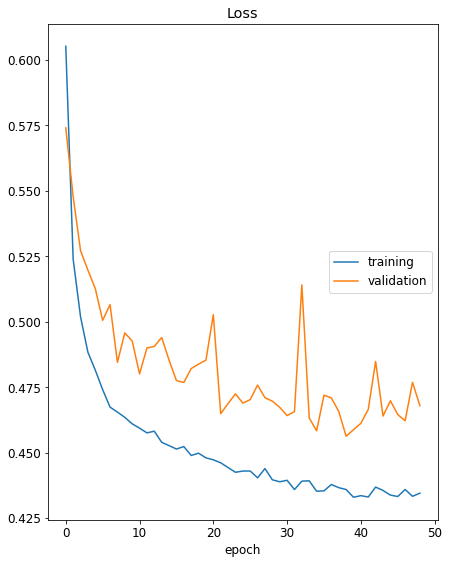

Loss
	training         	 (min:    0.433, max:    0.605, cur:    0.434)
	validation       	 (min:    0.456, max:    0.574, cur:    0.468)
Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
time: 7min 21s (started: 2021-05-04 01:18:59 +00:00)


In [ ]:
model = make_autoencoder(layer_sizes=deep_architecture, learning_rate=0.005)

nn_file = my_path + 'deep-lr_0.005.h5'
history = train_model(model, nn_file, X_tr_scaled, X_tr_scaled, seed=5,
                      max_epochs=200)

In [ ]:
X_tr_reconstr = model.predict(X_tr_scaled)
anomaly_scores = np.linalg.norm(X_tr_reconstr - X_tr_scaled, axis=1)


time: 3.22 s (started: 2021-05-04 01:26:20 +00:00)


Precision= 0.028674296001028676
Recall= 0.892
False Positive Rate =  0.05313992669869788
True Positive Rate =  0.892


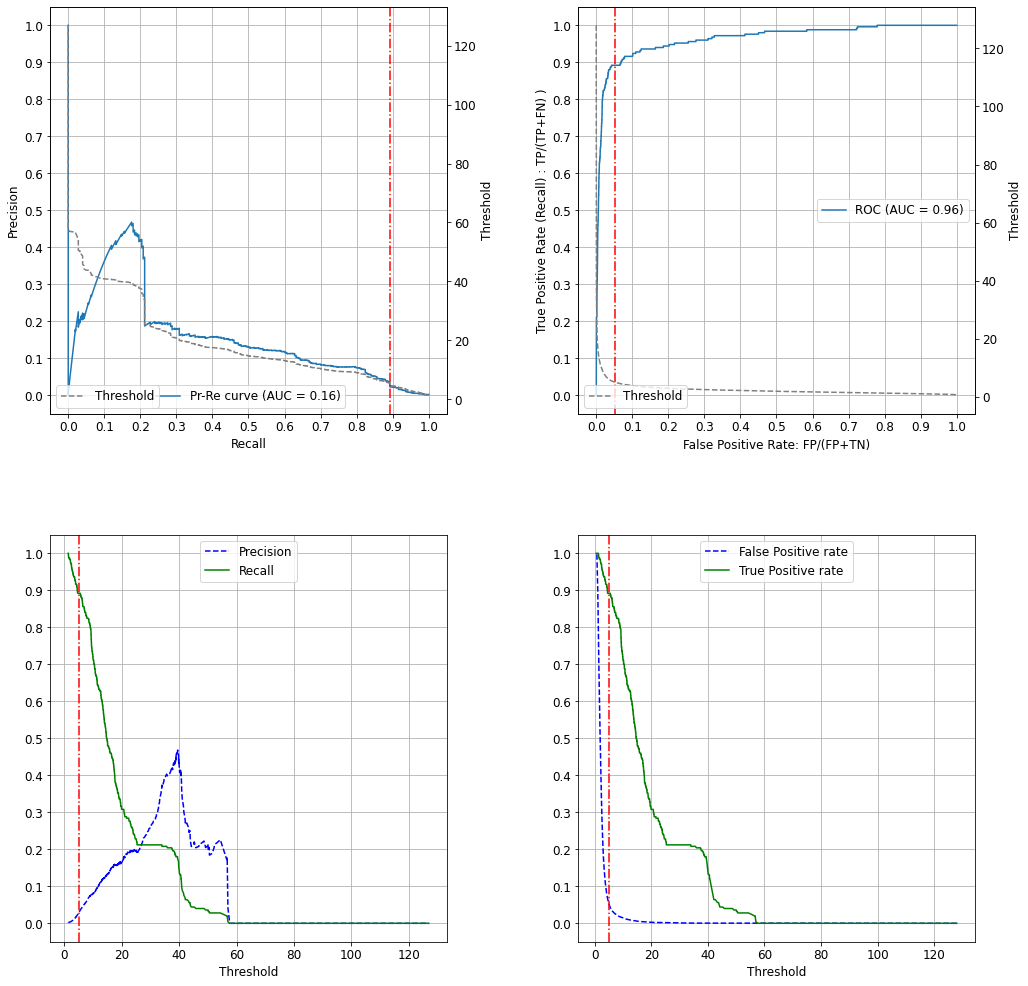

time: 2.16 s (started: 2021-05-04 01:26:23 +00:00)


In [ ]:
threshold_selected = 5
evaluate_anomaly_detector(y_train, anomaly_scores, threshold_selected)

In [ ]:
X_test_reconstr = model.predict(X_test_scaled)
anomaly_scores = np.linalg.norm(X_test_reconstr - X_test_scaled, axis=1)

y_pred = (anomaly_scores >= threshold_selected)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
fpr = false_positive_rate(y_test, y_pred)

print("Precision:", precision)
print("Recall: ", recall)
print("False Positive Rate:", fpr)

Precision: 0.027484694542138855
Recall:  0.871900826446281
False Positive Rate: 0.0525175504002476
time: 3.8 s (started: 2021-05-04 01:26:26 +00:00)


Normalized confusion matrix
[[0.94748245 0.05251755]
 [0.12809917 0.87190083]]


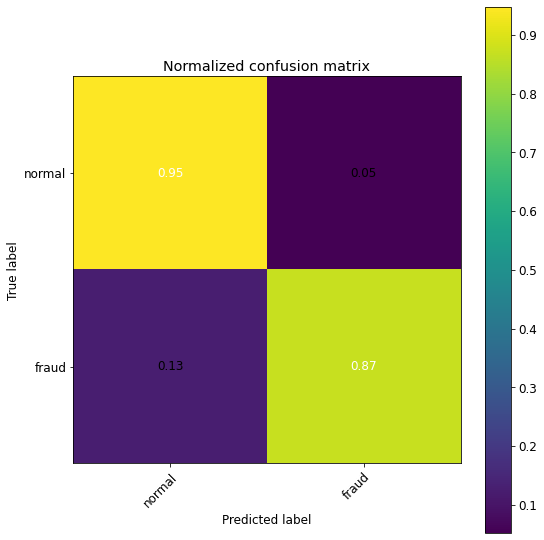

time: 624 ms (started: 2021-05-04 01:26:29 +00:00)


In [ ]:
plot_conf_mat(y_test, y_pred, class_names)

Let's try with a smaller learning rate

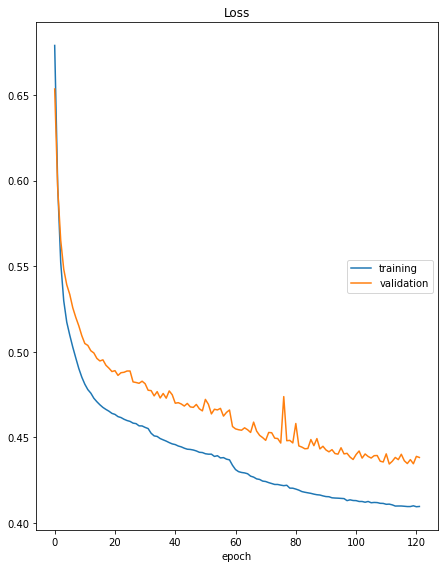

Loss
	training         	 (min:    0.409, max:    0.679, cur:    0.410)
	validation       	 (min:    0.434, max:    0.654, cur:    0.438)
Restoring model weights from the end of the best epoch.
Epoch 00122: early stopping
time: 27min 3s (started: 2021-05-04 07:01:22 +00:00)


In [ ]:
nn_file = my_path + 'deep-lr_0.001.h5'
model = make_autoencoder(layer_sizes=deep_architecture, learning_rate=0.001)
history = train_model(model, nn_file, X_tr_scaled, X_tr_scaled, seed=5,
                      max_epochs=200)

Google disconnected me. I will recover the last model.

In [ ]:
nn_file = my_path + 'deep-lr_0.001.h5'
model = load_model(nn_file)

time: 2.16 s (started: 2021-05-04 08:45:18 +00:00)


In [ ]:
X_tr_reconstr = model.predict(X_tr_scaled)
anomaly_scores = np.linalg.norm(X_tr_reconstr - X_tr_scaled, axis=1)


time: 2.3 s (started: 2021-05-04 08:46:28 +00:00)


Precision= 0.01765476832935009
Recall= 0.916
False Positive Rate =  0.08963581493179884
True Positive Rate =  0.916


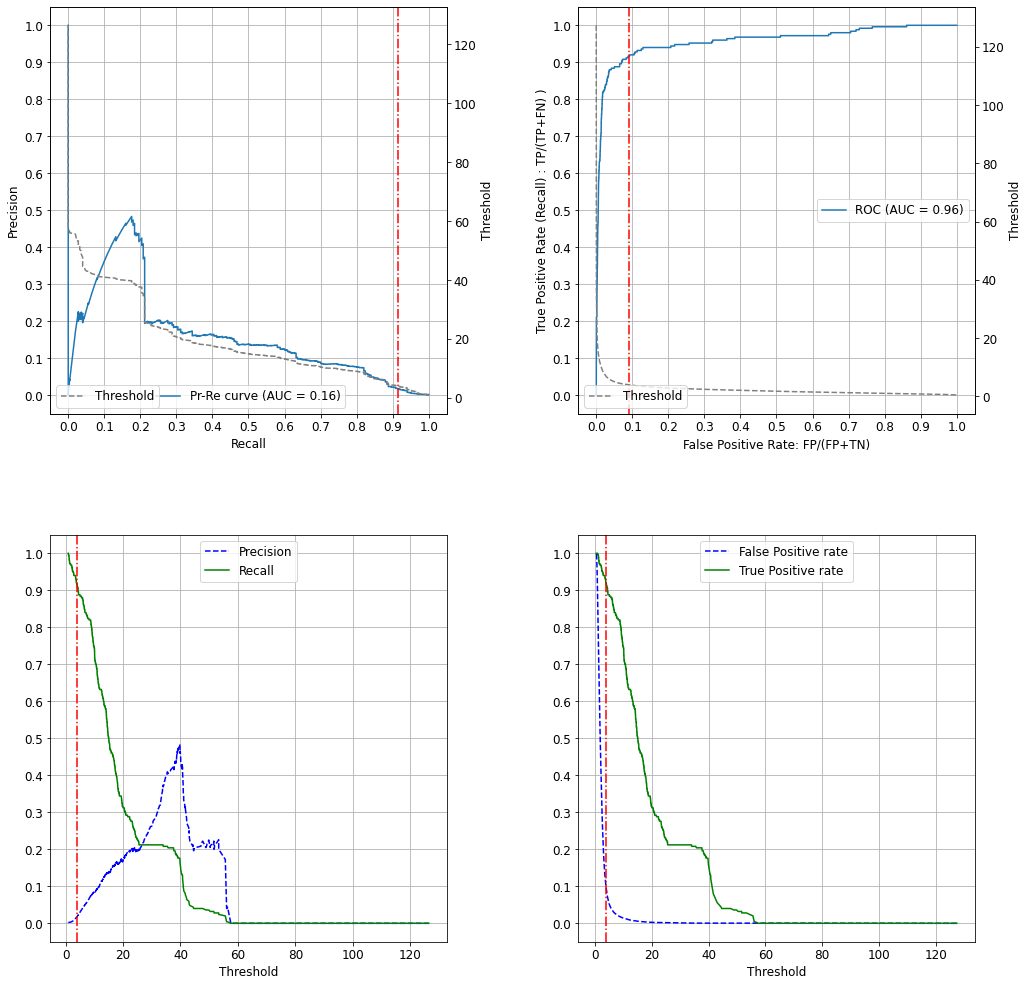

time: 2.16 s (started: 2021-05-04 08:47:45 +00:00)


In [ ]:
threshold_selected = 4
evaluate_anomaly_detector(y_train, anomaly_scores, threshold_selected)

In [ ]:
X_test_reconstr = model.predict(X_test_scaled)
anomaly_scores = np.linalg.norm(X_test_reconstr - X_test_scaled, axis=1)

y_pred = (anomaly_scores >= threshold_selected)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
fpr = false_positive_rate(y_test, y_pred)

print("Precision:", precision)
print("Recall: ", recall)
print("False Positive Rate:", fpr)

Precision: 0.01672631087599191
Recall:  0.8884297520661157
False Positive Rate: 0.08890561472123353
time: 2.49 s (started: 2021-05-04 08:49:41 +00:00)


# Other examples of Autoencoders for anomaly detection

* Application of autoencoders to the same dataset: Ch.8 of A. Patel, Hands-on unsupervised learning using Python, O'Reilly, 2019
* [Handwritten digits](https://visualstudiomagazine.com/articles/2019/03/01/neural-anomaly-detection-using-keras.aspx)